In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import copy
import matplotlib.pyplot as plt
import time  # Import time module for tracking

In [7]:
# from google.colab import drive

# # Mount your Google Drive to the Colab VM.
# drive.mount('/content/drive')

# # The path to your Google Drive folder where you want to save files.
# data_folder = '/content/drive/My Drive/Work/RMIT/datasets'

# The path to your Google Drive folder where you want to save files.
# data_folder = '../Work/RMIT/datasets'

# %cd "{data_folder}"

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# Check if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cpu')

In [11]:
def create_windows(data, input_window, output_window, scaler, step_size = 90):
    inputs = []
    targets = []
    for i in range(0, len(data) - input_window - output_window + 1, step_size):
        in_window = data[i:i + input_window]
        out_window = data[i + input_window:i + input_window + output_window]
        in_window = scaler.transform(in_window)
        inputs.append(in_window)  # Input window
        targets.append(out_window)  # Target window
    return inputs, targets

In [12]:
# Step 2: Define the LSTM model
class WeatherLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_size=5, output_window=30, dropout=0.3):
        super(WeatherLSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, output_size * output_window)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Attributes for output reshaping
        self.output_size = output_size
        self.output_window = output_window

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # Take the output from the last LSTM step
        x = lstm_out[:, -1, :]

        # First fully connected layer with BatchNorm and ReLU
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        # Apply dropout
        x = self.dropout(x)

        # Second fully connected layer for prediction
        x = self.fc2(x)

        # Reshape the output to match the desired prediction window
        out = x.view(-1, self.output_window, self.output_size)
        return out

In [13]:
class CNNWeatherPredictor(nn.Module):
    def __init__(self, input_size=5, output_size=5, kernel_size=3, num_filters=64, dropout=0.5):
        super(CNNWeatherPredictor, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size)
        self.fc1 = nn.Linear(num_filters * (90 - 2 * (kernel_size - 1)), 128)  # Adjust depending on the kernel size and input length
        self.fc2 = nn.Linear(128, output_size * 30)  # Assuming 30-day prediction

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input shape: (batch_size, time_steps, input_size)
        x = x.transpose(1, 2)  # Reshape to (batch_size, input_size, time_steps)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        # x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 30, 6)  # Reshape to (batch_size, 30 days, 6 features)

        return x

In [14]:
class GRUWeatherPredictor(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, output_size=4, output_window=30, dropout=0.5):
        super(GRUWeatherPredictor, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size * output_window)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.output_size = output_size
        self.output_window = output_window

    def forward(self, x):
        # GRU forward pass
        gru_out, _ = self.gru(x)
        x = gru_out[:, -1, :]  # Take the last GRU output
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.view(-1, self.output_window, self.output_size)
        return x

In [15]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.relu, self.dropout)

    def forward(self, x):
        return self.net(x)

class TCNWeatherPredictor(nn.Module):
    def __init__(self, input_size=4, output_size=4, num_channels=64, kernel_size=3, output_window=30, dropout=0.5):
        super(TCNWeatherPredictor, self).__init__()
        self.temporal_block = TemporalBlock(input_size, num_channels, kernel_size, stride=1, dilation=2, padding=2, dropout=dropout)
        # self.fc1 = nn.Linear(num_channels * (90 - 2 * (kernel_size - 1)), 128)  # Adjust based on input length and kernel size
        self.fc1 = nn.Linear(11264, 128)  # Adjust based on input length and kernel size
        self.fc2 = nn.Linear(128, output_size * output_window)
        self.output_size = output_size
        self.output_window = output_window

    def forward(self, x):
        # TCN forward pass
        x = x.transpose(1, 2)  # Switch time dimension for conv1d (batch_size, input_size, time_steps)
        x = self.temporal_block(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(-1, self.output_window, self.output_size)  # Reshape to output window
        return x

In [16]:
class TransformerWeatherPredictor(nn.Module):
    def __init__(self, input_size=6, num_heads=8, num_layers=2, hidden_size=64, output_size=6, output_window=30, dropout=0.1):
        super(TransformerWeatherPredictor, self).__init__()
        
        # Input embedding layer (input_size is now 4 for 4 features)
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Transformer layer
        self.transformer = nn.Transformer(hidden_size, num_heads, num_layers, num_layers, dropout=dropout)
        
        # Fully connected layers
        # self.fc1 = nn.Linear(hidden_size * output_window, 128)
        self.fc1 = nn.Linear(5760, 128)
        self.fc2 = nn.Linear(128, output_size * output_window)
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        
        # Output size parameters
        self.output_size = output_size
        self.output_window = output_window

    def forward(self, x):
        # Input x: (batch_size, time_steps, input_size)
        x = self.embedding(x)  # Embed the input into hidden_size dimensions
        x = x.transpose(0, 1)  # Transformer expects (sequence_length, batch_size, hidden_size)
        x = self.transformer(x, x)  # Forward through transformer
        x = x.transpose(0, 1)  # Back to (batch_size, sequence_length, hidden_size)
        
        # Flatten the sequence for fully connected layers
        x = x.reshape(x.size(0), -1)
        
        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        
        # Reshape the output to match (batch_size, output_window, output_size)
        x = x.view(-1, self.output_window, self.output_size)
        
        return x

In [17]:
# Cross-validation and training process with GPU support, plot tracking and model saving
def cross_validate_model(model, dataset, num_epochs=20, learning_rate=0.001, k_folds=5, weight_decay=1e-4, patience=20, reduction_factor=0.1):
    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Track results across folds
    fold_results = []


    total_start_time = time.time()  # Start timing the entire process
    best_val_loss_total = float('inf')

    # Start cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        best_val_loss = float('inf')  # Set initial best validation loss to infinity
        print(f'Fold {fold+1}/{k_folds}')

        # Reduce the training set size
        train_sampler = reduce_dataset(torch.utils.data.Subset(dataset, train_ids), reduction_factor=reduction_factor)
        val_sampler = reduce_dataset(torch.utils.data.Subset(dataset, val_ids), reduction_factor=reduction_factor)

        # Create DataLoaders
        train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

        # Initialize the model for this fold (a fresh copy)
        model_fold = copy.deepcopy(model)
        model_fold = model_fold.to(device)  # Move model to GPU

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(model_fold.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # criterion = nn.MSELoss()
        criterion = nn.L1Loss()

        # Store losses for each fold
        fold_train_losses = []
        fold_val_losses = []

        # Training process
        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # Start timing for this epoch
            model_fold.train()
            train_loss = 0.0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

                optimizer.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            # Validation process
            model_fold.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

                    outputs = model_fold(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            # Print milestone for each epoch
            epoch_end_time = time.time()  # End timing for this epoch
            epoch_time = epoch_end_time - epoch_start_time
            avg_val_loss = val_loss / len(val_loader)
            fold_val_losses.append(avg_val_loss)

            # Print milestone for each epoch
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5f}, Validation Loss: {avg_val_loss:.5f}, Epoch time: {epoch_time % 60:.3f} seconds")

            # Check if validation loss improves (early stopping)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement_epochs = 0
                best_model = copy.deepcopy(model_fold)
                print(f"\tEpoch {epoch+1} New best model found with Validation Loss: {best_val_loss:.5f}")

            else:
                no_improvement_epochs += 1

            # Early stopping condition
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

        # Track fold results
        fold_results.append(avg_val_loss)

        print(f'Fold {fold+1} finished with Validation Loss: {avg_val_loss}\n')
        # Plot training and validation loss
        # plt.plot(fold_train_losses, label=f'Train Loss Fold {fold+1}')
        plt.plot(pd.DataFrame(fold_train_losses, columns=['Loss'])['Loss'].rolling(window=7).mean(), label=f'Val Loss Fold {fold+1}')
        plt.plot(pd.DataFrame(fold_val_losses, columns=['ValLoss'])['ValLoss'].rolling(window=7).mean(), label=f'Val Loss Fold {fold+1}')
        plt.title('Training and Validation Loss' + ' Fold#' + str(fold+1))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        # plt.yscale('log')
        plt.legend()
        plt.show()

        if best_val_loss < best_val_loss_total:
            best_val_loss_total = best_val_loss

            # Save model after training
            # torch.save(model.state_dict(), "weather_lstm_model.pth")
            model_name = 'tcn_6_attr.pth'
            torch.save(best_model, model_name)
            print("\tModel saved as " + model_name + f" with Validation Loss: {best_val_loss_total:.5f}")

    # Estimate total training time
    total_end_time = time.time()
    total_time = total_end_time - total_start_time
    print(f'Total training time: {total_time // 60:.0f} minutes, {total_time % 60:.0f} seconds')

    # Calculate the average performance across all folds
    avg_loss = np.mean(fold_results)
    print(f'Cross-validation complete! Average Validation Loss: {avg_loss}')


In [18]:
def reduce_dataset(dataset, reduction_factor=0.1):
    """Reduce dataset by randomly sampling a fraction of the data."""
    # Total number of samples
    dataset_size = len(dataset)

    # Generate indices for the dataset
    indices = list(range(dataset_size))

    # Randomly select a subset of indices
    np.random.shuffle(indices)

    # Determine the size of the subset
    subset_size = int(reduction_factor * dataset_size)

    # Subset of indices to use
    subset_indices = indices[:subset_size]

    # Create a sampler with the subset of indices
    sampler = SubsetRandomSampler(subset_indices)

    return sampler

In [19]:
file_path = 'weatherAUS.csv'
df = pd.read_csv(file_path, index_col=None)

# Fill missing values for all columns except 'UV'
df[['MaxTemp', 'MinTemp', 'WindSpeed9am', 'WindSpeed3pm', 'Rainfall', 'Pressure9am', 'Pressure3pm']] = \
    df[['MaxTemp', 'MinTemp', 'WindSpeed9am', 'WindSpeed3pm', 'Rainfall', 'Pressure9am', 'Pressure3pm']].fillna(method='ffill')

# Fill missing values in 'UV' with 0
df[['Cloud9am','Cloud3pm']] = df[['Cloud9am','Cloud3pm']].fillna(0)

df['WindSpeed'] = df[['WindSpeed9am', 'WindSpeed3pm']].mean(axis=1)
df['UV'] = df[['Cloud9am', 'Cloud3pm']].mean(axis=1)
df['Pressure'] = df[['Pressure9am', 'Pressure3pm']].mean(axis=1)

df.rename(columns={'Rainfall': 'Precipitation'}, inplace=True)

# Include 'Location' in selected columns
selected_columns = ['MaxTemp', 'MinTemp', 'WindSpeed', 'Precipitation', 'Pressure', 'UV', 'Location']
df = df[selected_columns]
df.head()

/var/folders/vn/ry12gj7937g25x2qg7l9bh6c0000gn/T/ipykernel_39395/1658518546.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['MaxTemp', 'MinTemp', 'WindSpeed9am', 'WindSpeed3pm', 'Rainfall', 'Pressure9am', 'Pressure3pm']].fillna(method='ffill')


,MaxTemp,MinTemp,WindSpeed,Precipitation,Pressure,UV,Location
0,22.9,13.4,22.0,0.6,1007.40,4.0,Albury
1,25.1,7.4,13.0,0.0,1009.20,0.0,Albury
2,25.7,12.9,22.5,0.0,1008.15,1.0,Albury
3,28.0,9.2,10.0,0.0,1015.20,0.0,Albury
4,32.3,17.5,13.5,1.0,1008.40,7.5,Albury


In [20]:
# Initialize lists to store inputs and targets from all locations
all_inputs = []
all_targets = []
input_window = 90
output_window = 30

columns_to_scale = ['MaxTemp', 'MinTemp', 'WindSpeed', 'Precipitation', 'Pressure', 'UV']

# Step 1: Fit the MinMaxScaler on the entire dataset (except for the 'Location' column)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the entire dataset (excluding 'Location')
scaler.fit(df[columns_to_scale].to_numpy())

# Step 2: Transform the dataset using the fitted scaler
# df[columns_to_scale] = scaler.transform(df[columns_to_scale])


# Group the data by 'Location'
grouped = df.groupby('Location')

for location, group in grouped:
    # Drop 'Location' column for model input
    data = group.drop('Location', axis=1).values

    # Ensure there's enough data for sliding windows
    if len(data) >= 60 + 90:
        # # Normalize the data
        # scaler = MinMaxScaler(feature_range=(-1, 1))
        # data_scaled = scaler.fit_transform(data)

        # Create windows for this location
        inputs, targets = create_windows(data, input_window, output_window, scaler, step_size = 90)

        # Append to the main list
        all_inputs.extend(inputs)
        all_targets.extend(targets)
    else:
        print(f"Not enough data for location: {location}")

# Convert lists to numpy arrays and then to torch tensors
all_inputs = torch.tensor(np.array(all_inputs), dtype=torch.float32)
all_targets = torch.tensor(np.array(all_targets), dtype=torch.float32)

# Create the TensorDataset
dataset = TensorDataset(all_inputs, all_targets)


Fold 1/5
Epoch 1/10000, Training Loss: 149.62191, Validation Loss: 52.16234, Epoch time: 0.350 seconds
	Epoch 1 New best model found with Validation Loss: 52.16234
	Epoch 2 New best model found with Validation Loss: 10.19261
	Epoch 3 New best model found with Validation Loss: 8.83821
	Epoch 4 New best model found with Validation Loss: 7.85102
	Epoch 5 New best model found with Validation Loss: 6.45220
	Epoch 6 New best model found with Validation Loss: 5.12422
	Epoch 7 New best model found with Validation Loss: 4.68156
	Epoch 8 New best model found with Validation Loss: 4.32099
	Epoch 9 New best model found with Validation Loss: 4.19222
	Epoch 13 New best model found with Validation Loss: 4.05678
	Epoch 14 New best model found with Validation Loss: 3.99195
	Epoch 17 New best model found with Validation Loss: 3.82246
	Epoch 18 New best model found with Validation Loss: 3.77284
	Epoch 23 New best model found with Validation Loss: 3.75731
	Epoch 25 New best model found with Validation Los

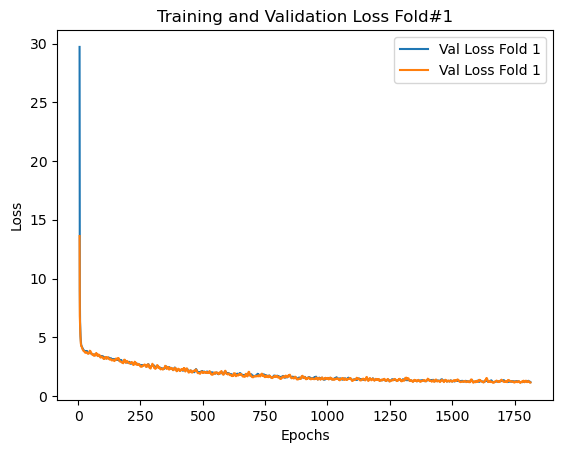

	Model saved as tcn_6_attr.pth with Validation Loss: 1.04375
Fold 2/5
Epoch 1/10000, Training Loss: 148.51335, Validation Loss: 48.99172, Epoch time: 0.106 seconds
	Epoch 1 New best model found with Validation Loss: 48.99172
	Epoch 2 New best model found with Validation Loss: 11.02049
	Epoch 3 New best model found with Validation Loss: 8.65384
	Epoch 4 New best model found with Validation Loss: 7.09415
	Epoch 5 New best model found with Validation Loss: 6.22591
	Epoch 6 New best model found with Validation Loss: 5.25939
	Epoch 7 New best model found with Validation Loss: 4.47963
	Epoch 8 New best model found with Validation Loss: 4.44441
	Epoch 10 New best model found with Validation Loss: 4.14733
	Epoch 12 New best model found with Validation Loss: 4.09071
	Epoch 13 New best model found with Validation Loss: 4.05983
	Epoch 15 New best model found with Validation Loss: 4.00061
	Epoch 17 New best model found with Validation Loss: 3.86721
	Epoch 20 New best model found with Validation Lo

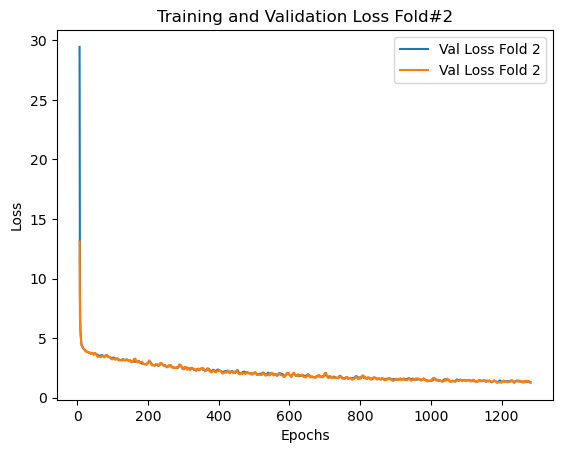

Fold 3/5
Epoch 1/10000, Training Loss: 148.83728, Validation Loss: 49.57451, Epoch time: 0.120 seconds
	Epoch 1 New best model found with Validation Loss: 49.57451
	Epoch 2 New best model found with Validation Loss: 10.70831
	Epoch 3 New best model found with Validation Loss: 9.19986
	Epoch 4 New best model found with Validation Loss: 7.57580
	Epoch 5 New best model found with Validation Loss: 6.39410
	Epoch 6 New best model found with Validation Loss: 5.42963
	Epoch 7 New best model found with Validation Loss: 4.66212
	Epoch 8 New best model found with Validation Loss: 4.41650
	Epoch 9 New best model found with Validation Loss: 4.34001
	Epoch 11 New best model found with Validation Loss: 4.05568
	Epoch 13 New best model found with Validation Loss: 3.98243
	Epoch 14 New best model found with Validation Loss: 3.90946
	Epoch 16 New best model found with Validation Loss: 3.88069
	Epoch 18 New best model found with Validation Loss: 3.83444
	Epoch 25 New best model found with Validation Los

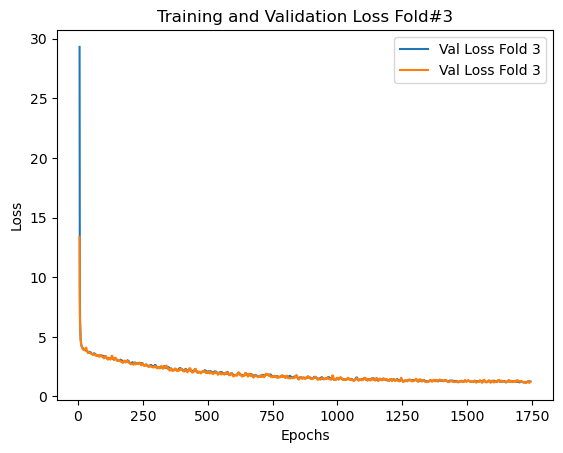

Fold 4/5
Epoch 1/10000, Training Loss: 149.49467, Validation Loss: 50.85144, Epoch time: 0.107 seconds
	Epoch 1 New best model found with Validation Loss: 50.85144
	Epoch 2 New best model found with Validation Loss: 11.14248
	Epoch 3 New best model found with Validation Loss: 9.05097
	Epoch 4 New best model found with Validation Loss: 7.52265
	Epoch 5 New best model found with Validation Loss: 6.79480
	Epoch 6 New best model found with Validation Loss: 5.23952
	Epoch 7 New best model found with Validation Loss: 5.00708
	Epoch 8 New best model found with Validation Loss: 4.48984
	Epoch 9 New best model found with Validation Loss: 4.30071
	Epoch 10 New best model found with Validation Loss: 4.14404
	Epoch 12 New best model found with Validation Loss: 4.08780
	Epoch 14 New best model found with Validation Loss: 4.00793
	Epoch 15 New best model found with Validation Loss: 3.94192
	Epoch 17 New best model found with Validation Loss: 3.92703
	Epoch 18 New best model found with Validation Los

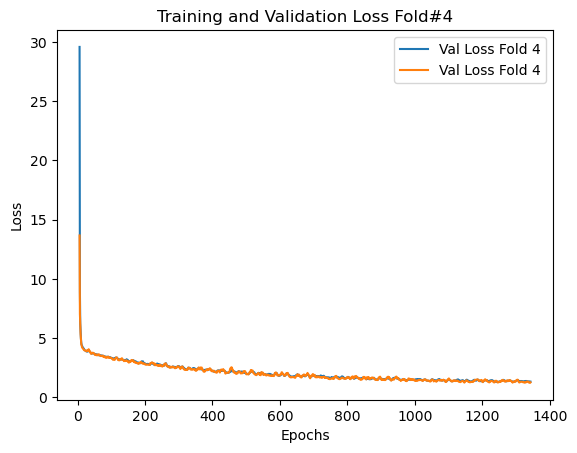

Fold 5/5
Epoch 1/10000, Training Loss: 148.74118, Validation Loss: 49.09316, Epoch time: 0.087 seconds
	Epoch 1 New best model found with Validation Loss: 49.09316
	Epoch 2 New best model found with Validation Loss: 12.08767
	Epoch 3 New best model found with Validation Loss: 9.23166
	Epoch 4 New best model found with Validation Loss: 7.92870
	Epoch 5 New best model found with Validation Loss: 6.62031
	Epoch 6 New best model found with Validation Loss: 5.40719
	Epoch 7 New best model found with Validation Loss: 4.49958
	Epoch 8 New best model found with Validation Loss: 4.41431
	Epoch 9 New best model found with Validation Loss: 4.15545
	Epoch 10 New best model found with Validation Loss: 4.14118
	Epoch 11 New best model found with Validation Loss: 4.12087
	Epoch 14 New best model found with Validation Loss: 3.95905
	Epoch 16 New best model found with Validation Loss: 3.95883
	Epoch 18 New best model found with Validation Loss: 3.90443
	Epoch 20 New best model found with Validation Los

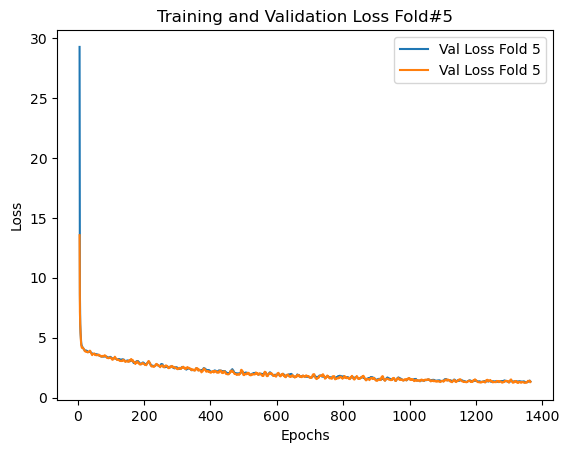

Total training time: 12 minutes, 33 seconds
Cross-validation complete! Average Validation Loss: 1.3748949074745176


In [350]:
# Step 5: Main script to run the model
# File path to the dataset

# Instantiate the model
# model = WeatherLSTM(input_size=6, hidden_size=64, num_layers=4,output_size=6, output_window=30, dropout=0).to(device)

# model = CNNWeatherPredictor(input_size=6, output_size=6, kernel_size=4, num_filters=32).to(device)

model = TCNWeatherPredictor(input_size=6, output_size=6, num_channels=128, kernel_size=4, output_window=30, dropout=0.0).to(device)

# model = TransformerWeatherPredictor(input_size=6, num_heads=8, num_layers=2, hidden_size=64, output_size=6, dropout=0.1).to(device)

# Train the model
cross_validate_model(model, dataset, num_epochs=10000, learning_rate=0.001, k_folds=5, reduction_factor=1, patience=100)

In [352]:
# Load the entire model
model = torch.load("tcn_6_attr.pth")

# Set the model to evaluation mode
model.eval()

model = model.cpu()

# Example of making a prediction
# input_data = torch.randn(1, 90, 6).to(device)  # Example input: batch of 1, 90 time steps, 6 features
# data_scaled = scaler.transform(data[0:90])

# Convert to a PyTorch tensor and reshape to (batch_size=1, time_steps=90, features=6)
data_scaled = torch.tensor(inputs[0], dtype=torch.float32).unsqueeze(0)

with torch.no_grad():  # Disable gradients for inference
    prediction = model(data_scaled)

# print(prediction)

# Inverse transform the predictions to get them back to the original scale
predicted_values = prediction.cpu().numpy().reshape(-1, 6)  # Convert to numpy
# predicted_values = scaler.inverse_transform(predicted_values)
predicted_values[:, 2:] = np.where(predicted_values[:, 2:] < 0, 0, predicted_values[:, 2:])

# Now predicted_values contains the original scaled values (e.g., temperatures, wind speed, etc.)
for row in (predicted_values):
    print(["{:.2f}".format(x) for x in row])
# 	MaxTemp	MinTemp	WindSpeed	Precipitation	Pressure	UV

['32.34', '21.85', '18.06', '0.00', '1014.68', '2.11']
['32.83', '22.46', '20.24', '1.29', '1013.58', '1.80']
['26.83', '18.92', '24.60', '1.35', '1016.88', '2.83']
['23.57', '11.82', '20.05', '2.65', '1022.32', '2.20']
['23.22', '8.38', '20.83', '0.95', '1023.42', '2.84']
['21.91', '8.93', '15.45', '1.17', '1026.63', '1.81']
['24.89', '8.94', '21.30', '0.36', '1025.87', '0.33']
['25.74', '11.84', '23.07', '1.03', '1028.73', '1.26']
['25.75', '10.66', '21.82', '0.00', '1026.86', '0.71']
['23.64', '9.47', '8.90', '0.52', '1025.27', '2.81']
['26.14', '8.26', '6.81', '0.95', '1025.85', '3.63']
['26.75', '8.69', '8.21', '1.51', '1020.75', '2.75']
['26.02', '10.04', '6.87', '2.53', '1018.04', '6.25']
['26.09', '12.85', '15.08', '3.90', '1016.29', '4.20']
['24.57', '12.64', '19.40', '0.60', '1017.19', '4.53']
['25.34', '10.42', '17.23', '0.44', '1021.08', '1.45']
['23.53', '11.03', '18.91', '0.00', '1020.90', '1.85']
['24.56', '9.43', '9.81', '1.02', '1020.91', '0.00']
['23.58', '9.38', '10.

C:\Users\narin\AppData\Local\Temp\ipykernel_39000\2511389451.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("tcn_6_attr.pth")


In [17]:
for row in scaler.inverse_transform(inputs[0]):
    print(["{:.2f}".format(x) for x in row])

['29.70', '16.80', '27.00', '0.00', '1010.50', '0.00']
['28.60', '13.30', '24.50', '0.00', '1015.40', '0.00']
['32.00', '14.90', '16.50', '0.00', '1014.00', '0.00']
['36.30', '16.30', '20.00', '0.00', '1011.35', '0.50']
['38.40', '20.00', '16.50', '0.00', '1011.00', '0.00']
['40.20', '20.20', '18.00', '0.00', '1008.70', '1.00']
['33.30', '19.70', '25.00', '0.00', '1010.75', '0.00']
['31.40', '15.20', '29.50', '0.00', '1015.00', '0.50']
['33.30', '15.80', '18.50', '0.00', '1012.90', '0.50']
['33.90', '17.50', '12.00', '0.00', '1008.55', '0.50']
['33.30', '18.10', '15.50', '0.00', '1009.05', '0.50']
['38.40', '17.40', '19.50', '0.00', '1011.85', '0.00']
['42.20', '22.00', '19.50', '0.00', '1009.25', '0.00']
['40.70', '23.60', '22.50', '0.00', '1009.60', '0.00']
['31.50', '19.00', '33.00', '0.00', '1015.80', '2.00']
['32.70', '15.70', '26.00', '0.00', '1018.85', '0.00']
['33.50', '16.60', '24.00', '0.00', '1017.80', '0.50']
['35.60', '18.50', '13.50', '0.00', '1014.65', '0.50']
['39.60', 

In [78]:
for row in targets[0]:
    print(["{:.2f}".format(x) for x in row])

# for row in targets[0]:
    # print(["{:.2f}".format(x) for x in row])
# MaxTemp	MinTemp	WindSpeed	Precipitation	Pressure	UV	

['34.60', '18.50', '12.00', '0.00', '1015.85', '0.00']
['35.20', '19.60', '3.00', '0.00', '1016.75', '0.00']
['26.10', '17.80', '34.00', '0.00', '1020.70', '4.00']
['23.40', '13.10', '20.00', '0.00', '1024.60', '3.50']
['23.70', '12.20', '25.00', '0.00', '1024.00', '1.00']
['21.90', '13.40', '28.50', '0.00', '1025.65', '0.50']
['21.90', '10.70', '27.50', '0.00', '1026.95', '0.00']
['25.00', '11.30', '14.00', '0.00', '1024.45', '1.50']
['26.00', '12.40', '15.00', '0.00', '1019.80', '1.00']
['27.00', '12.60', '12.00', '0.00', '1019.30', '5.00']
['28.90', '13.10', '11.50', '0.00', '1019.95', '1.00']
['30.30', '14.90', '13.00', '0.00', '1019.45', '1.00']
['30.50', '13.30', '8.00', '0.00', '1017.65', '1.00']
['24.90', '14.30', '10.00', '0.00', '1015.40', '7.00']
['26.70', '15.40', '20.50', '1.00', '1015.05', '1.00']
['24.30', '12.80', '17.50', '0.00', '1016.35', '2.50']
['25.90', '12.80', '14.00', '0.00', '1018.75', '0.50']
['27.00', '12.30', '16.50', '0.00', '1021.75', '0.00']
['25.90', '1

In [186]:
group.iloc[90:120].iloc[90:120]

,MaxTemp,MinTemp,WindSpeed,Precipitation,Pressure,UV,Location


In [187]:
group[columns_to_scale].iloc[90:120]

,MaxTemp,MinTemp,WindSpeed,Precipitation,Pressure,UV
105652,0.489603,0.273585,-0.727273,-1.000000,0.197347,-1.000
105653,0.512287,0.325472,-0.931818,-1.000000,0.227197,-1.000
105654,0.168242,0.240566,-0.227273,-1.000000,0.358209,0.000
105655,0.066163,0.018868,-0.545455,-1.000000,0.487562,-0.125
105656,0.077505,-0.023585,-0.431818,-1.000000,0.467662,-0.750
105657,0.009452,0.033019,-0.352273,-1.000000,0.522388,-0.875
105658,0.009452,-0.094340,-0.375000,-1.000000,0.565506,-1.000
105659,0.126654,-0.066038,-0.681818,-1.000000,0.482587,-0.625
105660,0.164461,-0.014151,-0.659091,-1.000000,0.328358,-0.750
105661,0.202268,-0.004717,-0.727273,-1.000000,0.311774,0.250


In [131]:
for row in scaler.inverse_transform(group[['MaxTemp', 'MinTemp', 'WindSpeed', 'Precipitation', 'Pressure', 'UV']].iloc[90:120]):
    print(["{:.2f}".format(x) for x in row])

['34.60', '18.50', '50.59', '979.75', '4.79', '0.00']
['35.20', '19.60', '12.65', '979.75', '4.91', '0.00']
['26.10', '17.80', '143.34', '979.75', '5.43', '44.00']
['23.40', '13.10', '84.32', '979.75', '5.95', '38.50']
['23.70', '12.20', '105.40', '979.75', '5.87', '11.00']
['21.90', '13.40', '120.15', '979.75', '6.09', '5.50']
['21.90', '10.70', '115.94', '979.75', '6.26', '0.00']
['25.00', '11.30', '59.02', '979.75', '5.93', '16.50']
['26.00', '12.40', '63.24', '979.75', '5.31', '11.00']
['27.00', '12.60', '50.59', '979.75', '5.25', '55.00']
['28.90', '13.10', '48.48', '979.75', '5.33', '11.00']
['30.30', '14.90', '54.81', '979.75', '5.27', '11.00']
['30.50', '13.30', '33.73', '979.75', '5.03', '11.00']
['24.90', '14.30', '42.16', '979.75', '4.73', '77.00']
['26.70', '15.40', '86.43', '979.91', '4.68', '11.00']
['24.30', '12.80', '73.78', '979.75', '4.86', '27.50']
['25.90', '12.80', '59.02', '979.75', '5.17', '5.50']
['27.00', '12.30', '69.56', '979.75', '5.57', '0.00']
['25.90', '1

In [21]:
import pickle

# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [50]:
prediction.cpu().numpy().reshape(-1, 4) 

array([[3.2984620e-01, 1.7472899e-01, 0.0000000e+00, 0.0000000e+00],
       [3.1254900e-01, 1.8442224e-01, 0.0000000e+00, 0.0000000e+00],
       [3.0573738e-01, 1.7010149e-01, 0.0000000e+00, 0.0000000e+00],
       [2.8096968e-01, 1.6241181e-01, 0.0000000e+00, 0.0000000e+00],
       [2.7869675e-01, 1.5551688e-01, 0.0000000e+00, 1.5961068e-36],
       [2.7495873e-01, 1.4133833e-01, 0.0000000e+00, 0.0000000e+00],
       [2.9235402e-01, 1.3406923e-01, 0.0000000e+00, 0.0000000e+00],
       [2.9716584e-01, 1.4480899e-01, 0.0000000e+00, 0.0000000e+00],
       [2.9082379e-01, 1.4955564e-01, 0.0000000e+00, 0.0000000e+00],
       [3.0326393e-01, 1.6262251e-01, 0.0000000e+00, 0.0000000e+00],
       [2.9513937e-01, 1.6553715e-01, 0.0000000e+00, 0.0000000e+00],
       [2.8758162e-01, 1.7898849e-01, 0.0000000e+00, 0.0000000e+00],
       [2.8413790e-01, 1.7701092e-01, 0.0000000e+00, 0.0000000e+00],
       [2.8306738e-01, 1.6504890e-01, 0.0000000e+00, 0.0000000e+00],
       [2.9130179e-01, 1.6067781e-